In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from model_day import get_data

raw_data, df_final, final_date = get_data()

data = load_dataset("boomsss/SPX_full_30min", split='train')

rows = [d['text'] for d in data]
rows = [x.split(',') for x in rows]

fr = pd.DataFrame(columns=[
    'Datetime','Open','High','Low','Close'
], data = rows)

fr['Datetime'] = pd.to_datetime(fr['Datetime'])
fr['Datetime'] = fr['Datetime'].dt.tz_localize('America/New_York')
fr = fr.set_index('Datetime')
fr['Open'] = pd.to_numeric(fr['Open'])
fr['High'] = pd.to_numeric(fr['High'])
fr['Low'] = pd.to_numeric(fr['Low'])
fr['Close'] = pd.to_numeric(fr['Close'])

Found cached dataset text (C:/Users/WINSTON-ITX/.cache/huggingface/datasets/boomsss___text/boomsss--SPX_full_30min-37ae67efd8a1cc91/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)
Merging econ data: 100%|██████████| 8/8 [00:00<00:00, 999.03it/s]
Found cached dataset text (C:/Users/WINSTON-ITX/.cache/huggingface/datasets/boomsss___text/boomsss--SPX_full_30min-37ae67efd8a1cc91/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


In [2]:
gap_data = raw_data['CurrentGap']
gap_data = gap_data.reset_index()
gap_data.columns = ['Date','CurrentGap']

In [3]:
data = fr.loc['2018-07-01':]

In [4]:
data['Date'] = pd.to_datetime(data.index.date)
data['HourMin'] = [f'{str(h).zfill(2)}{str(m).zfill(2)}' for h,m in zip(data.index.hour, data.index.minute)]
data = data.merge(gap_data, how = 'left', on ='Date')

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1330294508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data.index.date)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1330294508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['HourMin'] = [f'{str(h).zfill(2)}{str(m).zfill(2)}' for h,m in zip(data.index.hour, data.index.minute)]


In [5]:
data.dtypes

Open                 float64
High                 float64
Low                  float64
Close                float64
Date          datetime64[ns]
HourMin               object
CurrentGap           float64
dtype: object

In [6]:
faulty = ['0900', '1600', '1630', '1700']
data1 = data.loc[~data['HourMin'].isin(faulty)]

data1['RowNumber'] = data1.groupby('Date').cumcount() + 1

high_idx = data1.groupby('Date')['High'].idxmax()
data1['HighBar'] = data1['RowNumber'].where(data1.index.isin(high_idx)) > 0

low_idx = data1.groupby('Date')['High'].idxmin()
data1['LowBar'] = data1['RowNumber'].where(data1.index.isin(low_idx)) > 0

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\3315939868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['RowNumber'] = data1.groupby('Date').cumcount() + 1
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\3315939868.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['HighBar'] = data1['RowNumber'].where(data1.index.isin(high_idx)) > 0
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\3315939868.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

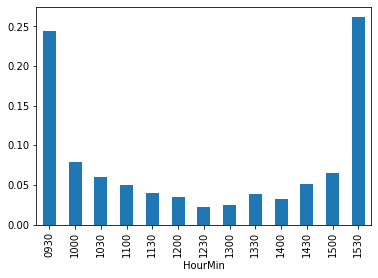

In [7]:
data1.groupby('HourMin')['HighBar'].mean().plot(kind='bar');

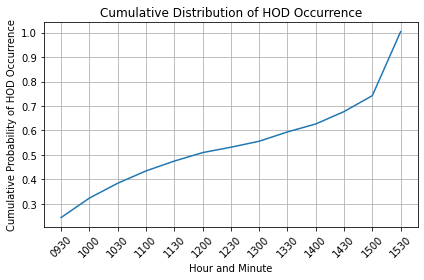

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

hod_prob = data1.groupby('HourMin')['HighBar'].mean()

hod_prob_sorted = hod_prob.sort_index()

cumulative_prob = hod_prob_sorted.cumsum()

# Plot the cumulative distribution curve
plt.plot(cumulative_prob.index, cumulative_prob.values)
plt.xlabel('Hour and Minute')
plt.ylabel('Cumulative Probability of HOD Occurrence')
plt.title('Cumulative Distribution of HOD Occurrence')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

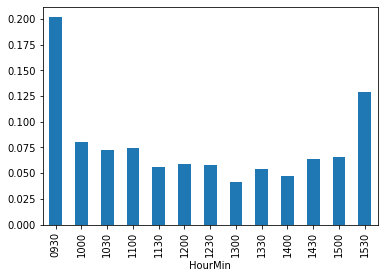

In [9]:
data1.groupby('HourMin')['LowBar'].mean().plot(kind='bar');

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'data1' with the 'HourMin', 'HighBar', and 'LowBar' columns

# Calculate the probability of High of Day (HOD) occurrence for each 'HourMin'
hod_prob = data1.groupby('HourMin')['HighBar'].mean()

# Calculate the probability of Low of Day (LOD) occurrence for each 'HourMin'
lod_prob = data1.groupby('HourMin')['LowBar'].mean()

# Sort the probabilities based on 'HourMin'
hod_prob_sorted = hod_prob.sort_index()
lod_prob_sorted = lod_prob.sort_index()

# Calculate the cumulative distributions
cumulative_hod = hod_prob_sorted.cumsum()
cumulative_lod = lod_prob_sorted.cumsum()

# Create a 2x4 grid of subplots with shared Y-axis
fig, axs = plt.subplots(2, 2, figsize=(16, 8),)

# Plot bar plot distributions of HOD and LOD
axs[0, 0].bar(hod_prob.index, hod_prob.values)
axs[0, 0].set_xlabel('Hour and Minute')
axs[0, 0].set_ylabel('Probability of HOD Occurrence')
axs[0, 0].set_title('Distribution of HOD Occurrence')
axs[0, 0].set_xticklabels(hod_prob.index, rotation=45)
axs[0, 0].grid()

# Format labels as percentages
axs[0, 0].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(hod_prob.index, hod_prob.values):
    axs[0, 0].text(x, y, f'{y:.0%}', ha='center', va='bottom')

axs[0, 1].bar(lod_prob.index, lod_prob.values, color='orange')
axs[0, 1].set_xlabel('Hour and Minute')
axs[0, 1].set_ylabel('Probability of LOD Occurrence')
axs[0, 1].set_title('Distribution of LOD Occurrence')
axs[0, 1].set_xticklabels(lod_prob.index, rotation=45)
axs[0, 1].grid()

# Format labels as percentages
axs[0, 1].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(lod_prob.index, lod_prob.values):
    axs[0, 1].text(x, y, f'{y:.0%}', ha='center', va='bottom')

# Plot cumulative distributions of HOD and LOD
axs[1, 0].plot(cumulative_hod.index, cumulative_hod.values)
axs[1, 0].set_xlabel('Hour and Minute')
axs[1, 0].set_ylabel('Cumulative Probability of HOD Occurrence')
axs[1, 0].set_title('Cumulative Distribution of HOD Occurrence')
axs[1, 0].set_xticklabels(cumulative_hod.index, rotation=45)
axs[1, 0].grid()

# Format labels as percentages
axs[1, 0].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(cumulative_hod.index, cumulative_hod.values):
    axs[1, 0].text(x, y, f'{y:.0%}', ha='center', va='bottom')

axs[1, 1].plot(cumulative_lod.index, cumulative_lod.values, color='orange')
axs[1, 1].set_xlabel('Hour and Minute')
axs[1, 1].set_ylabel('Cumulative Probability of LOD Occurrence')
axs[1, 1].set_title('Cumulative Distribution of LOD Occurrence')
axs[1, 1].set_xticklabels(cumulative_lod.index, rotation=45)
axs[1, 1].grid()

# Format labels as percentages
axs[1, 1].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(cumulative_lod.index, cumulative_lod.values):
    axs[1, 1].text(x, y, f'{y:.0%}', ha='center', va='bottom')

# # Remove unused subplots
# fig.delaxes(axs[1, 2])
# fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.show()


C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1950565345.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(hod_prob.index, rotation=45)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1950565345.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(lod_prob.index, rotation=45)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1950565345.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(cumulative_hod.index, rotation=45)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1950565345.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(cumulative_lod.index, rotation=45)


In [11]:
data1.columns

Index(['Open', 'High', 'Low', 'Close', 'Date', 'HourMin', 'CurrentGap',
       'RowNumber', 'HighBar', 'LowBar'],
      dtype='object')

In [19]:
data1['CurrentGapCat'].dtypes

CategoricalDtype(categories=[(-0.0757, -0.00306], (-0.00306, -0.000396], (-0.000396, 0.00136], (0.00136, 0.00364], (0.00364, 0.0478]], ordered=True)

[('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.14%', '0.36%'), ('0.14

In [ ]:
XXX

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'data1' with the 'HourMin', 'HighBar', and 'LowBar' columns

# List of values to filter and plot
data1['CurrentGapCat'] = pd.qcut(data1['CurrentGap'], 5)

# Function to convert a float to a percentage string with desired precision
def float_to_percent(value, precision=2):
    return "{:.{precision}%}".format(value, precision=precision)

# Loop through the categories and convert the float intervals to percentage format
formatted_categories = []
for category in data1['CurrentGapCat']:
    # Get the lower and upper bounds of the interval and convert them to percentage strings
    lower_bound = float_to_percent(category.left, precision=2)
    upper_bound = float_to_percent(category.right, precision=2)
    formatted_categories.append((lower_bound, upper_bound))

print(formatted_categories)
data1['Labels'] = formatted_categories

tuples = list(set([s for s in zip(data1['CurrentGapCat'], data1['Labels'])]))

# Create a 1x2 grid of subplots with shared Y-axis
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Loop through the specified values and plot the cumulative distributions
for t in tuples:
    # Filter the DataFrame based on the specified value
    gap = t[0]
    lbl = t[1]
    df_use = data1.loc[data1['CurrentGapCat'] == gap]  # Replace 'column_to_filter' with the appropriate column name
    
    # Calculate the probability of High of Day (HOD) occurrence for each 'HourMin'
    hod_prob = df_use.groupby('HourMin')['HighBar'].mean()
    
    # Calculate the probability of Low of Day (LOD) occurrence for each 'HourMin'
    lod_prob = df_use.groupby('HourMin')['LowBar'].mean()

    # Sort the probabilities based on 'HourMin'
    hod_prob_sorted = hod_prob.sort_index()
    lod_prob_sorted = lod_prob.sort_index()

    # Calculate the cumulative distributions
    cumulative_hod = hod_prob_sorted.cumsum()
    cumulative_lod = lod_prob_sorted.cumsum()

    # Plot cumulative distributions of HOD and LOD and assign them to the legend
    axs[0].plot(cumulative_hod.index, cumulative_hod.values, label=lbl)
    axs[1].plot(cumulative_lod.index, cumulative_lod.values, label=lbl)

# Set labels and title for the left plot (HOD)
axs[0].set_xlabel('Hour and Minute')
axs[0].set_ylabel('Cumulative Probability of HOD Occurrence')
axs[0].set_title('Cumulative Distribution of HOD Occurrence')
axs[0].set_xticklabels(cumulative_hod.index, rotation=45)
axs[0].grid()

# Format labels as percentages
axs[0].yaxis.set_major_formatter('{:.0%}'.format)

# Set labels and title for the right plot (LOD)
axs[1].set_xlabel('Hour and Minute')
axs[1].set_ylabel('Cumulative Probability of LOD Occurrence')
axs[1].set_title('Cumulative Distribution of LOD Occurrence')
axs[1].set_xticklabels(cumulative_lod.index, rotation=45)
axs[1].grid()

# Format labels as percentages
axs[1].yaxis.set_major_formatter('{:.0%}'.format)

# Add legend to the plots
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()


[('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.14%', '0.36%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('-0.04%', '0.14%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.36%', '4.78%'), ('0.14%', '0.36%'), ('0.14

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1885325193.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(cumulative_hod.index, rotation=45)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_11332\1885325193.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(cumulative_lod.index, rotation=45)


In [13]:
data1.query('HourMin == "0930" & HighBar == True')

Open     High      Low    Close       Date HourMin  CurrentGap  \
14     2733.27  2736.58  2730.35  2732.58 2018-07-03    0930    0.004043   
121    2801.43  2803.71  2796.75  2798.78 2018-07-16    0930   -0.003248   
247    2842.35  2843.17  2834.73  2834.73 2018-07-27    0930    0.000064   
261    2819.00  2821.74  2812.14  2813.36 2018-07-30    0930    0.002544   
429    2827.95  2827.95  2814.59  2814.66 2018-08-15    0930    0.004637   
...        ...      ...      ...      ...        ...     ...         ...   
17254  4226.71  4231.10  4215.56  4217.66 2023-05-30    0930   -0.003514   
17268  4190.74  4195.44  4184.54  4185.02 2023-05-31    0930    0.000766   
17338  4285.47  4299.19  4284.97  4295.32 2023-06-07    0930    0.000274   
17436  4440.95  4448.47  4425.67  4429.61 2023-06-16    0930   -0.003057   
17599  4422.62  4422.62  4395.21  4398.22 2023-07-06    0930   -0.001598   

       RowNumber  HighBar  LowBar          CurrentGapCat  
14             1     True   False      (0.00364, 0.0478]  
121            1     True   False    (-0.0757, -0.00306]  
247            1     True   False   (-0.000396, 0.00136]  
261            1     True   False     (0.00136, 0.00364]  
429            1     True   False      (0.00364, 0.0478]  
...          ...      ...     ...                    ...  
17254          1     True   False    (-0.0757, -0.00306]  
17268          1     True   False   (-0.000396, 0.00136]  
17338          1     True   False   (-0.000396, 0.00136]  
17436          1     True   False  (-0.00306, -0.000396]  
17599          1     True   False  (-0.00306, -0.000396]  

[310 rows x 11 columns]